# Kaggle Cancer Detection

## Background/Motivation
The dataset is from an older (2019) Kaggle competition (before I got into deep learning).
While the competition already expired, I thought the dataset was easy to understand and would give me a view of how image classification can be used to detect cancer.

#### Original dataset/competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection
Info (from Kaggle): Identify metastatic tissue in histopathologic scans of lymph node sections

## Summary Steps
- Downloaded the data separately (7GB). Includes images and labels
- Read the files and visualized (both positive and negative examples)
- Partitioned the data into training/test samples
- Created a Convolutional Neural Network (different configurations) and trained the network for classification

## Summary Results
- With a very tiny network able to get 70% test accuracy
- Increasing it to a moderate size, able to get ~85% test accuracy
- Expect to get better results with a much larger network, but will need to run on a GPU (TBD)
    


---
---

### Step1: Data Download
- Image files stored in 'images' folder
- Total of 220025 files (tif format)
- For faster iteration/testing copied a subset (10%) of the images to 'images_subset' folder
- labels downloaded to 'labels.csv'.  This csv file (from kaggle) has the tif file name and a 0/1 label


### Step2: Read images and labels

In [50]:
import os
import cv2
import torch
import csv
import re

def read_labels(csv_filename):
    labels = dict()
    with open(csv_filename,'r') as file:
        csv_reader = csv.reader(file)
    
        for row in csv_reader:
            labels[row[0]] = row[1]

    return labels


def lookup_label(image_filename, label_dict):
    file_pfx = re.sub('.tif', '', image_filename)
    if file_pfx not in label_dict:
        print("Error, label not found", file_pfx)

    return label_dict[file_pfx]
    

def read_tif_images(directory_path, label_dict):
    tensor_list = list()
    labels = list()

    # Iterate over all the files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory_path, filename)

            # Read the image using OpenCV
            img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            # Convert the NumPy array to a PyTorch tensor
            # also normalize from 0-255 to floating point 0-1
            img_tensor = torch.from_numpy(img/255)
            img_tensor = img_tensor.to(dtype=torch.float32)

            # The Conv2D layer expects channels to first. So change order
            img_tensor = img_tensor.permute(2, 0, 1)  
            
            # Append the image tensor to the list
            tensor_list.append(img_tensor)
            label = lookup_label(filename, label_dict)
            labels.append(int(label))

    return tensor_list, labels


label_dict = read_labels('labels.csv')
tensor_list, labels = read_tif_images('images_subset', label_dict)



### Visualize some of the samples

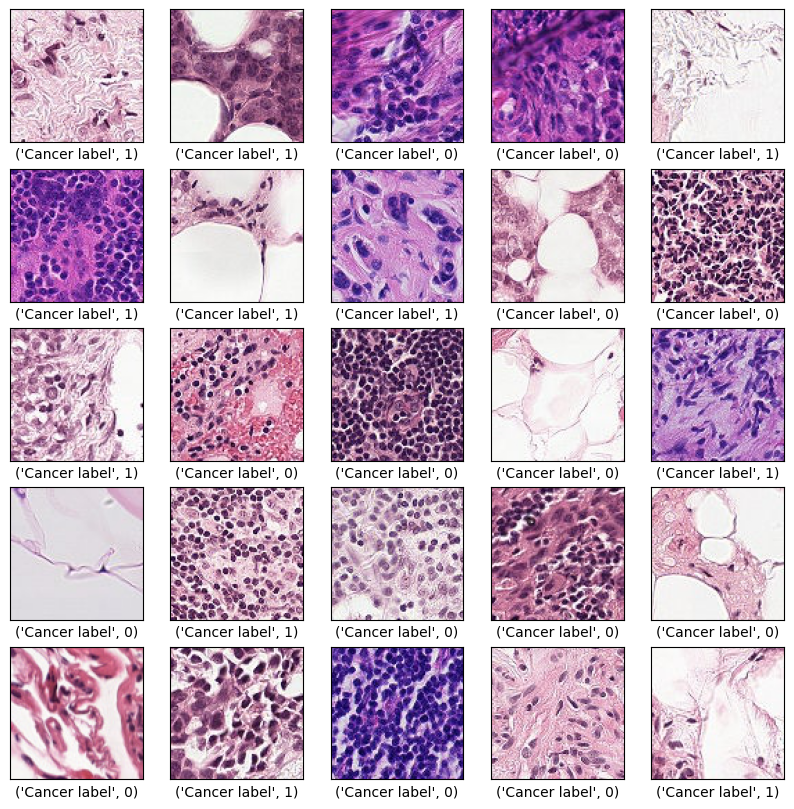

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tensor_list[i].permute(1,2,0))
    label = "Cancer label", train_y[i].item()
    plt.xlabel(label)
plt.show()

### Split into Train/Test

In [52]:
def create_train_test(tensor_list, labels):
    train_pct = 90
    train_len = int(train_pct * len(tensor_list) /100)
    print(train_len)
    
    train_x = torch.stack(tensor_list[0:train_len], dim=0)
    train_y = torch.tensor(labels[0:train_len])

    test_x = torch.stack(tensor_list[train_len:], dim=0)
    test_y = torch.tensor(labels[train_len:])

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test(tensor_list, labels)



36852


### Create a CNN network (experiment with different layers/params)

In [34]:
from torch import nn

[n, c, image_h, image_w] = train_x.shape
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(int(64 * image_h/4 * image_w/4), 100)
        self.linear1 = nn.Linear(100, 10)
        self.rl = nn.ReLU()
        self.linear2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(self.rl(self.conv1(x)))
        x = self.pool(self.rl(self.conv2(x)))

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.linear1(x)
        x = self.rl(x)
        y = self.linear2(x)

        return y

model = NeuralNetwork().to('cpu')
print(model)



NeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=10, bias=True)
  (rl): ReLU()
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


### Train the network and check test accuracy

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

def get_multi_class_acc(pred_y, label_y):
    tot_cnt = len(label_y)
    acc_cnt = 0
    for i in range(tot_cnt):
        indx = torch.argmax(pred_y[i])
        if indx == label_y[i]:
            acc_cnt += 1
    acc = float(100) * acc_cnt / tot_cnt
    #print("acc", acc)
    return acc

def get_batch(data_x, data_y):
    batch_size = 256
    ix = torch.randint(len(data_x), (batch_size,))
    x = torch.stack([data_x[i] for i in ix])
    y = torch.stack([data_y[i] for i in ix])
    #x, y = x.to(device), y.to(device)
    return x, y

import time
model.train() #superflous, but documentation refers useful if doing dropout, etc
start_time = time.time()
desired_accuracy = 90
num_iterations = 6000
for i in range(num_iterations):
    model.train()
    train_x_batch, train_y_batch = get_batch(train_x, train_y)
    pred = model(train_x_batch)
    loss = loss_fn(pred, train_y_batch)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    if i%10 == 0:
        print("Checking performance")
        model.eval()
        pred = model(train_x[0:1000])
        train_acc = get_multi_class_acc(pred, train_y[0:1000])
        pred = model(test_x)
        test_acc = get_multi_class_acc(pred, test_y)
        print(i, "train_acc", train_acc, "test_acc", test_acc)
        if test_acc > desired_accuracy:
            print("Achieved target", i, "train_acc", train_acc, "test_acc", test_acc)
            break
end_time = time.time()
print("time taken", end_time - start_time)


Checking performance
0 train_acc 62.0 test_acc 61.953601953601954
Checking performance
10 train_acc 75.9 test_acc 74.0903540903541
Checking performance
20 train_acc 83.4 test_acc 80.78144078144078
Checking performance
30 train_acc 85.3 test_acc 81.75824175824175
Checking performance
40 train_acc 84.8 test_acc 81.78266178266178
Checking performance
50 train_acc 85.2 test_acc 82.14896214896216
Checking performance
60 train_acc 85.2 test_acc 82.12454212454213
Checking performance
70 train_acc 85.5 test_acc 82.85714285714286
Checking performance
80 train_acc 84.5 test_acc 82.34432234432235
Checking performance
90 train_acc 85.8 test_acc 83.17460317460318
Checking performance
100 train_acc 85.3 test_acc 82.27106227106228
Checking performance
110 train_acc 85.7 test_acc 82.90598290598291
Checking performance
120 train_acc 85.8 test_acc 83.07692307692308
Checking performance
130 train_acc 87.1 test_acc 82.93040293040293
Checking performance
140 train_acc 84.9 test_acc 82.97924297924298
Checki

### Plot some results

In [43]:
pred_y = model(test_x)

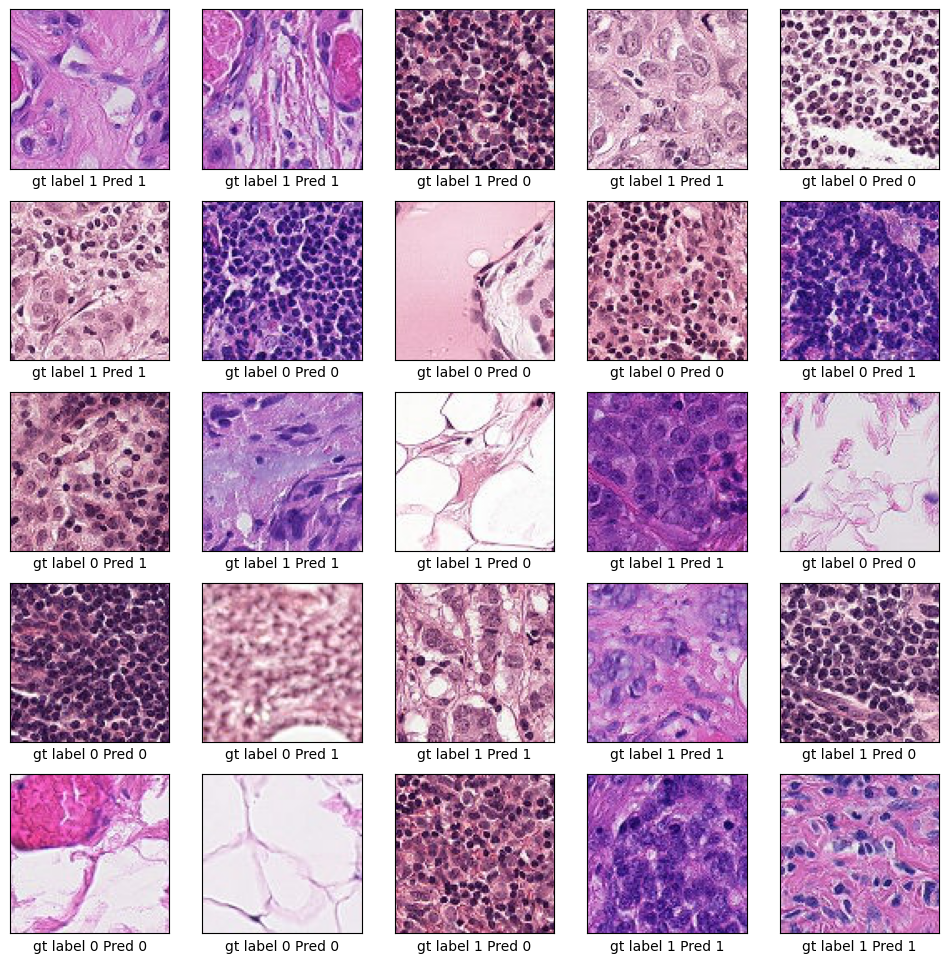

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_x[i].permute(1,2,0))
    pred_indx = torch.argmax(pred_y[i])
    match = 0
    if pred_indx == test_y[i]:
        match = 1
    label = "gt label " + str(test_y[i].item()) + " Pred " + str(pred_indx.item())
    plt.xlabel(label)
plt.show()